# Predict wind based on other weather variables

This notebook will use time lags to train a machine learning model for predicting wind speed. 

First, we select a random station. The data is kept at daily resolution. Then, we generate a lagged feature matrix.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import glob
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [2]:
data_dir = '/datasets/NOAA_SST/'
#load(data_dir + “noaa_gsod/…/file”
t0 = time.time()
data = pd.read_pickle(data_dir+'noaa_gsod/Combined_noaa_gsod') # load weather data
stations = pd.read_pickle(data_dir+'noaa_gsod.stations') # load station data

# # USE ONLY 2008-2018 # #
data = data.loc[data.index >= pd.Timestamp(2008, 1, 1)]
data = data.drop(columns=['yr','year','da','mo']) # don't need these anymore
print(time.time()-t0)

23.815101861953735


In [3]:
stations.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
0,007018,99999,WXPOD 7018,None,None,None,0.00,0.000,+7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,None,None,0.00,0.000,+7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,None,None,0.00,0.000,+7070.0,20140923,20150926
3,008268,99999,WXPOD8278,AF,None,None,32.95,65.567,+1156.7,20100519,20120323
4,008307,99999,WXPOD 8318,AF,None,None,0.00,0.000,+8318.0,20100421,20100421


In [4]:
data.head()

,stn,temp,slp,wdsp,mxpsd,max,min,prcp
Datetime,,,,,,,,
2008-08-22,619970,41.7,1032.1,7.2,14.0,46.6,37.8,0.00
2008-09-28,714170,54.9,1023.8,9.1,15.0,70.3,51.4,0.06
2008-02-14,041560,35.6,1032.8,28.5,38.9,36.5,34.5,0.00
2008-02-25,041560,4.5,997.1,4.3,7.0,10.4,-1.1,0.00
2008-10-06,041650,43.3,998.8,24.3,30.9,44.6,40.3,0.00


In [5]:
%%time
# # SELECT RANDOM STATION # #
np.random.seed(30)
rs = np.unique(data['stn'].values) # find unique stations with data
rand_stat = rs[randint(len(rs))] # pick a random station

# # ideally we should check < len(np.unique(data.index)), but many are shorter
while (len(data.loc[data['stn'] == rand_stat]) < 3650): # If not enough data
    if len(stations.loc[stations['usaf'] == rand_stat]): # If station info available
        if (stations.loc[stations['usaf'] == rand_stat].iloc[0]['wban'] != '99999'): # If station number not unique
            rand_stat = rs[randint(len(rs))] # get a new station
    else:
        rand_stat = rs[randint(len(rs))] # get a new station

select_station = stations.loc[stations['usaf'] == rand_stat] # get location, etc, for random station



CPU times: user 30.2 s, sys: 2.84 s, total: 33.1 s
Wall time: 32.6 s


In [36]:
features = data.loc[data['stn'] == rand_stat] # pick weather at random station
features = features.drop(columns='stn')
features = features.sort_index()
select_station.head() # see where it is

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
24140,711320,99999,STONY RAPIDS ARPT,CA,None,CYSF,59.25,-105.833,+0250.0,19860725,20190401


In [37]:
features.head()

,temp,slp,wdsp,mxpsd,max,min,prcp
Datetime,,,,,,,
2008-01-01,-8.3,1035.4,1.4,5.1,-2.2,-16.6,0.01
2008-01-02,-6.9,1022.2,4.2,9.9,8.6,-20.2,0.00
2008-01-03,9.2,996.6,2.0,9.9,14.0,-0.4,0.04
2008-01-04,7.9,998.0,3.4,9.9,19.4,-4.0,0.00
2008-01-05,6.8,995.4,9.7,12.0,18.9,-4.9,0.13


### Time-shift the data

In [38]:
#features = features.drop(columns='mxpsd') # Drop maximum wind speed that day
columns = features.columns # weather variables

for co in columns:
    # one day lag
    features[co + '_lag1'] = features[co].shift(periods=1)
    
    # two days lag
    features[co + '_lag2'] = features[co].shift(periods=2)
    
    # three days lag
    features[co + '_lag3'] = features[co].shift(periods=3)
features = features.iloc[3:]
print(str(len(features)) + ' samples, ' + str(len(features.columns)) + ' features.')
features.head()

3991 samples, 28 features.


,temp,slp,wdsp,mxpsd,max,min,prcp,temp_lag1,temp_lag2,temp_lag3,...,mxpsd_lag3,max_lag1,max_lag2,max_lag3,min_lag1,min_lag2,min_lag3,prcp_lag1,prcp_lag2,prcp_lag3
Datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-04,7.9,998.0,3.4,9.9,19.4,-4.0,0.00,9.2,-6.9,-8.3,...,5.1,14.0,8.6,-2.2,-0.4,-20.2,-16.6,0.04,0.00,0.01
2008-01-05,6.8,995.4,9.7,12.0,18.9,-4.9,0.13,7.9,9.2,-6.9,...,9.9,19.4,14.0,8.6,-4.0,-0.4,-20.2,0.00,0.04,0.00
2008-01-06,4.0,993.5,8.5,13.0,9.7,2.7,0.09,6.8,7.9,9.2,...,9.9,18.9,19.4,14.0,-4.9,-4.0,-0.4,0.13,0.00,0.04
2008-01-07,4.7,1001.9,0.6,2.9,5.5,3.0,0.05,4.0,6.8,7.9,...,9.9,9.7,18.9,19.4,2.7,-4.9,-4.0,0.09,0.13,0.00
2008-01-08,-4.2,1011.6,0.3,2.9,5.5,-8.3,0.06,4.7,4.0,6.8,...,12.0,5.5,9.7,18.9,3.0,2.7,-4.9,0.05,0.09,0.13


In [33]:
# View station locations
fig = plt.figure(figsize=(18.5, 10.5))
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180, resolution='l')
m.drawmapboundary(fill_color='xkcd:lightblue')
m.fillcontinents(color='xkcd:green',lake_color='xkcd:lightblue')
m.drawmeridians(np.arange(-180.,180.,30.),labels=[True,False,False,True])
m.drawparallels(np.arange(-90.,90,30.),labels=[False,True,True,False])
lon = select_station['lon'].tolist()
lat = select_station['lat'].tolist()
#xpt,ypt = m(lon,lat)
m.plot(lon, lat,'r+') 
#m.plot(179.75, -19.133, 'ro')
plt.show()

NameError: name 'Basemap' is not defined

<Figure size 1332x756 with 0 Axes>

In [39]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [41]:
import seaborn as sns

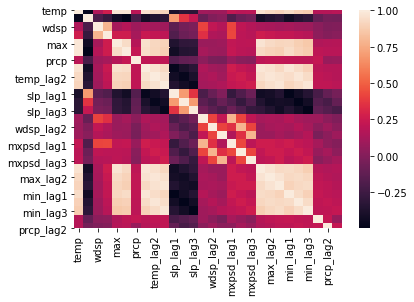

In [42]:
sns.heatmap(features.corr())

In [45]:
get_top_abs_correlations(features, 20)

temp       max          0.981961
temp_lag1  max_lag1     0.981939
temp_lag2  max_lag2     0.981917
temp_lag3  max_lag3     0.981899
temp       min          0.980842
temp_lag1  min_lag1     0.980823
temp_lag2  min_lag2     0.980802
temp_lag3  min_lag3     0.980787
max        max_lag1     0.968172
max_lag1   max_lag2     0.968134
max_lag2   max_lag3     0.968088
temp       temp_lag1    0.961510
temp_lag1  temp_lag2    0.961443
temp_lag2  temp_lag3    0.961403
temp       max_lag1     0.960219
temp_lag1  max_lag2     0.960164
temp_lag2  max_lag3     0.960126
max        temp_lag1    0.957615
temp_lag2  max_lag1     0.957557
temp_lag3  max_lag2     0.957507
dtype: float64

### Create train/val/test

In [10]:
ylabel = features['wdsp'] # use today's wind speed as the label
features = features.drop(columns='wdsp') # don't put it in training data!!

# Use 20% test split (80% training + validation)
ntrain = int(len(features)*0.8)
x_test = features.iloc[ntrain:,:]
y_test = ylabel[ntrain:]
indices = np.arange(ntrain)

# Split remaining 80% into training-validation sets (of original data)
x_train, x_val, y_train, y_val, train_ind, val_ind = train_test_split(features.iloc[0:ntrain,:], ylabel[0:ntrain], indices, 
                                                  test_size=0.2, random_state=1)

# Scale features. Fit scaler on training only.
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

### Predict with Random Forest

In [11]:
# # Create, train, and predict random forest here # #

clf = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 10)
clf.fit(x_train, y_train)

y_test_pred = clf.predict(x_test)
y_train_pred = clf.predict(x_train)
y_val_pred = clf.predict(x_val)

In [12]:
regr = clf

In [13]:
train_pred_df = pd.Series(data = y_train_pred, index = features.iloc[train_ind].index)
val_pred_df = pd.Series(data = y_val_pred, index = features.iloc[val_ind].index)

In [14]:
train_pred_df = train_pred_df.append(val_pred_df)
train_pred_df = train_pred_df.sort_index()

In [15]:
train_pred_df

Datetime
2008-01-04    3.581341
2008-01-05    8.409071
2008-01-06    7.837458
2008-01-07    6.777890
2008-01-08    3.060939
                ...   
2016-10-07    4.715997
2016-10-08    4.541685
2016-10-09    3.050150
2016-10-10    3.811203
2016-10-11    4.271131
Length: 3192, dtype: float64

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
mean_squared_error(y_test, y_test_pred)

4.587456719465586

In [19]:
mean_squared_error(y_train, y_train_pred)

1.9576900507233845

In [20]:
mean_squared_error(y_val, y_val_pred)

4.720965045122381

In [16]:
features.iloc[0:ntrain].index

DatetimeIndex(['2008-01-04', '2008-01-05', '2008-01-06', '2008-01-07',
               '2008-01-08', '2008-01-09', '2008-01-10', '2008-01-11',
               '2008-01-12', '2008-01-13',
               ...
               '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05',
               '2016-10-06', '2016-10-07', '2016-10-08', '2016-10-09',
               '2016-10-10', '2016-10-11'],
              dtype='datetime64[ns]', name='Datetime', length=3192, freq=None)

### Plot the random forest

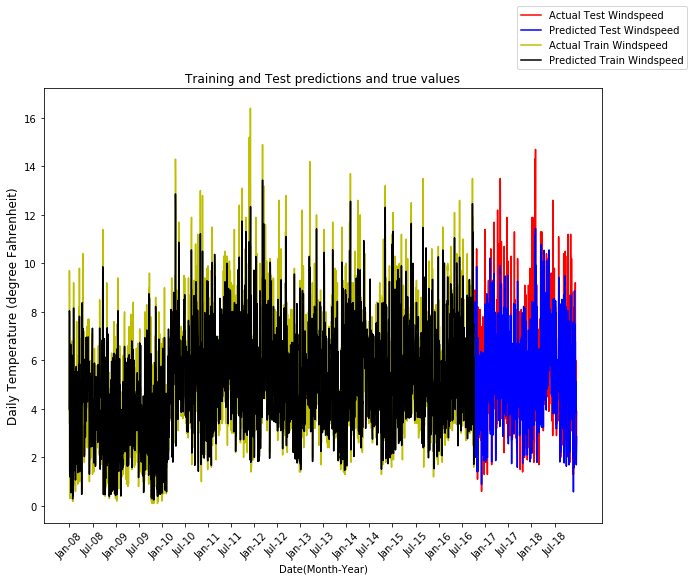

In [98]:
# plot predictions
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(features.iloc[ntrain:].index,y_test, 'r', label="Actual Test Windspeed") # plot actual temperature
ax.plot(features.iloc[ntrain:].index, y_test_pred, 'b', label="Predicted Test Windspeed") # plot predicted temperature

# # PLOT THE PREDICTED TRAINING AND VALIDATION DATA HERE # #
ax.plot(features.iloc[0:ntrain].index, ylabel[0:ntrain], 'y', label="Actual Train Windspeed")
ax.plot(features.iloc[0:ntrain].index, train_pred_df, 'k', label="Predicted Train Windspeed")

#plt.plot(features.iloc[val_ind].index, y_val, 'm', label="Actual Val Temperature")
#plt.plot(features.iloc[val_ind].index, y_val_pred, 'c', label="Predicted Val Temperature")

# # INCREASE X TICK SPACING, UPDATE LEGEND # #
ax.set_xticks(features.iloc[:].index[::182]) # set xticks to monthly
ax.set_xticklabels(ax.get_xticks(), rotation=45)
myFmt = mdates.DateFormatter('%b-%y')
plt.gca().xaxis.set_major_formatter(myFmt)
ax.set_title('Training and Test predictions and true values')
ax.set_ylabel('Daily Temperature (degree Fahrenheit)', fontsize=12)
ax.set_xlabel('Date(Month-Year)')
lgd = ax.legend(bbox_to_anchor=(1, 1.2), loc='upper center')
fig.savefig("problem 2_temp(a).png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# # Plot the feature importances # #


In [28]:
from sklearn.metrics import mean_squared_error

In [19]:
mean_squared_error(y_test, y_test_pred)

4.587456719465586

In [20]:
mean_squared_error(ylabel[train_ind], y_train_pred)

1.9576900507233845

In [21]:
mean_squared_error(ylabel[val_ind], y_val_pred)

4.720965045122381

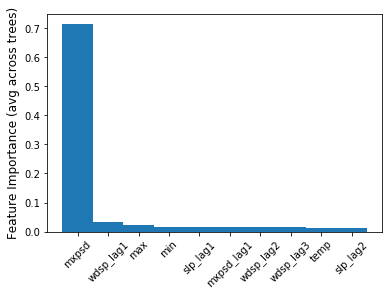

In [70]:
nfeatures = 10
fi = regr.feature_importances_ # get feature importances
fi_sort = np.argsort(fi)[::-1] # sort importances most to least
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]], width=1, \
        tick_label=features.columns.values[fi_sort[0:nfeatures]]) # plot features importances
plt.ylabel('Feature Importance (avg across trees)', fontsize=12)
plt.xticks(rotation = 45)
plt.show()

## Hyperparameter tuning

In [11]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, PredefinedSplit

In [35]:
train_ind

array([ 335, 1804,  533, ..., 1096,  235, 1061])

In [37]:
val_ind

array([2865,  165, 1782, 2234, 1727,  675, 2284, 1426, 1654,  340, 2045,
        161, 3016,   13,  494,  495,  730,  898, 1792, 2124, 2584, 1453,
       1509,  797,   75, 1404,  321,  110, 1599, 1330,  205, 2478,  481,
       1452,  368, 2941, 2032,  349, 3073,   45,  829, 1089, 1498,   99,
       1410, 1988, 2467, 2820, 1201, 1000, 2456,  988,  203, 1729,   98,
        666, 1248, 2114, 2301, 2241, 2554,    3,  790,  442,  857, 1909,
       2160,  486,  685, 1999, 1197, 2893, 2480,  954, 1677, 2598, 1928,
        383,   12, 1730, 2744, 2539, 2455, 1353, 1144,  534, 3020, 2975,
       2963,  282, 2198,  581,   28, 2933, 1783,  126, 2932,  586,    6,
        713, 1631, 1151,  171,  521, 2914,  291, 3029, 2054, 1036, 2490,
        393, 1447,  630, 2142, 1142, 2985, 2347, 3068, 2466,  896, 2088,
        772, 2448,  490, 2765, 2623,  602,  610, 2362, 2901, 2276,  846,
        783, 3136,  136, 1624,  123, 2885,  808, 1074, 1546, 2433, 2862,
       2385, 3153, 1784,  921,  855,  816, 2119,  2

In [41]:
features.iloc[0:ntrain]

,temp,slp,max,min,prcp,temp_lag1,temp_lag2,temp_lag3,slp_lag1,slp_lag2,...,wdsp_lag3,max_lag1,max_lag2,max_lag3,min_lag1,min_lag2,min_lag3,prcp_lag1,prcp_lag2,prcp_lag3
Datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-04,7.9,998.0,19.4,-4.0,0.00,9.2,-6.9,-8.3,996.6,1022.2,...,1.4,14.0,8.6,-2.2,-0.4,-20.2,-16.6,0.04,0.00,0.01
2008-01-05,6.8,995.4,18.9,-4.9,0.13,7.9,9.2,-6.9,998.0,996.6,...,4.2,19.4,14.0,8.6,-4.0,-0.4,-20.2,0.00,0.04,0.00
2008-01-06,4.0,993.5,9.7,2.7,0.09,6.8,7.9,9.2,995.4,998.0,...,2.0,18.9,19.4,14.0,-4.9,-4.0,-0.4,0.13,0.00,0.04
2008-01-07,4.7,1001.9,5.5,3.0,0.05,4.0,6.8,7.9,993.5,995.4,...,3.4,9.7,18.9,19.4,2.7,-4.9,-4.0,0.09,0.13,0.00
2008-01-08,-4.2,1011.6,5.5,-8.3,0.06,4.7,4.0,6.8,1001.9,993.5,...,9.7,5.5,9.7,18.9,3.0,2.7,-4.9,0.05,0.09,0.13
2008-01-09,-14.7,1016.6,-2.2,-25.4,0.01,-4.2,4.7,4.0,1011.6,1001.9,...,8.5,5.5,5.5,9.7,-8.3,3.0,2.7,0.06,0.05,0.09
2008-01-10,-14.5,1017.9,-5.8,-25.4,0.01,-14.7,-4.2,4.7,1016.6,1011.6,...,0.6,-2.2,5.5,5.5,-25.4,-8.3,3.0,0.01,0.06,0.05
2008-01-11,-11.5,1017.0,-9.4,-14.8,0.01,-14.5,-14.7,-4.2,1017.9,1016.6,...,0.3,-5.8,-2.2,5.5,-25.4,-25.4,-8.3,0.01,0.01,0.06
2008-01-12,-17.6,1025.4,-8.9,-25.6,0.00,-11.5,-14.5,-14.7,1017.0,1017.9,...,0.7,-9.4,-5.8,-2.2,-14.8,-25.4,-25.4,0.01,0.01,0.01


In [12]:
split_index = [-1 if x in train_ind else 0 for x in range(0, ntrain)]

In [38]:
a = np.array([1,2,3])

In [39]:
if 1 in a:
    print("yes")

yes


In [13]:
split_index

[-1,
 -1,
 -1,
 0,
 0,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 -1,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 0,
 -1,
 -1,
 -1,


In [14]:
pds = PredefinedSplit(test_fold = split_index)

In [15]:
n_estimators_values = [50, 100, 300, 800, 1500, 2000]
max_features_values = ["log2", "sqrt", "auto"]
max_depth_values = [5, 7, 10, 15, 20, 50, 80, 150, None]
min_samples_split_values = [2, 3, 5, 7, 10]
bootstrap_values = [True, False]
criterion_values = ["mse", "mae"]

In [16]:
search_grid = {
    'n_estimators' : n_estimators_values,
    'max_features' : max_features_values,
    'max_depth' : max_depth_values,
    'min_samples_split' : min_samples_split_values,
    'bootstrap' : bootstrap_values,
    'criterion' : criterion_values,
}

In [17]:
clf = RandomForestRegressor()

In [19]:
rf_cross_validator = RandomizedSearchCV(estimator = clf, param_distributions = search_grid, cv = pds, n_iter = 100, verbose = 2, n_jobs = -1)

In [20]:
rf_cross_validator.fit(features.iloc[:ntrain], ylabel[:ntrain])

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 58.3min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  0])),
                   error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimat...
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_di

In [22]:
rf_cross_validator.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'mse',
 'bootstrap': True}

In [23]:
improved_clf = RandomForestRegressor(n_estimators = 300, min_samples_split = 2, max_features='sqrt', max_depth=None, criterion='mse', bootstrap=True) 

In [24]:
improved_clf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [25]:
y_test_pred = improved_clf.predict(x_test)
y_train_pred = improved_clf.predict(x_train)
y_val_pred = improved_clf.predict(x_val)

In [29]:
mean_squared_error(y_test, y_test_pred)

4.504801911556112

In [30]:
mean_squared_error(ylabel[train_ind], y_train_pred)

0.533681596814205

In [31]:
mean_squared_error(ylabel[val_ind], y_val_pred)

4.636304262041383

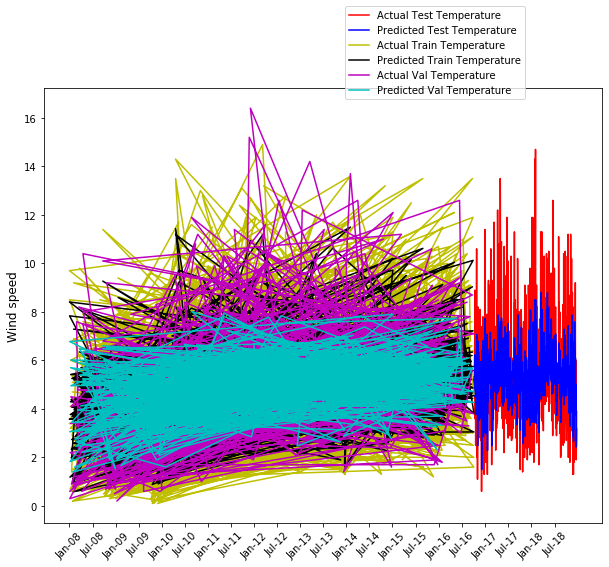

In [22]:
# plot predictions
plt.figure(figsize=(10,8))
plt.plot(features.iloc[ntrain:].index,y_test, 'r', label="Actual Test Temperature") # plot actual wind speed
plt.plot(features.iloc[ntrain:].index, y_test_pred, 'b', label="Predicted Test Temperature") # plot predicted wind speed, y is the prediction results on testing data

# # PLOT TRAINING DATA HERE # #

plt.plot(features.iloc[train_ind].index, y_train, 'y', label="Actual Train Temperature")
plt.plot(features.iloc[train_ind].index, y_train_pred, 'k', label="Predicted Train Temperature")

plt.plot(features.iloc[val_ind].index, y_val, 'm', label="Actual Val Temperature")
plt.plot(features.iloc[val_ind].index, y_val_pred, 'c', label="Predicted Val Temperature")


# # INCREASE X TICK SPACING, UPDATE LEGEND # #
plt.xticks(features.index[::182], rotation = 45) # X-Ticks are spaced once every 30 days. 
myFmt = mdates.DateFormatter('%b-%y') # This shows day-month-year. Switch to month-year or annually
plt.gca().xaxis.set_major_formatter(myFmt)
plt.legend(bbox_to_anchor=(0.7, 1.2), loc='upper center')
plt.ylabel('Wind speed', fontsize=12)
plt.savefig("Problem2_Wind.png")
plt.show()


In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
mean_squared_error(y_test, y_test_pred)

4.718490770914938

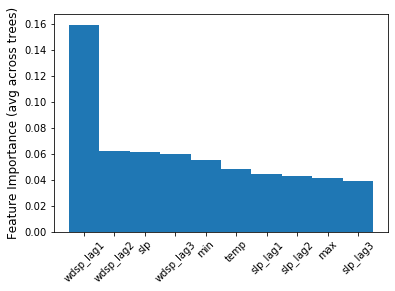

In [34]:
# # Plot the feature importances # #
nfeatures = 10
fi = improved_clf.feature_importances_ # get feature importances, regr is the regressor
fi_sort = np.argsort(fi)[::-1] # sort importances most to least
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]], width=1, \
        tick_label=features.columns.values[fi_sort[0:nfeatures]]) # plot features importances
plt.ylabel('Feature Importance (avg across trees)', fontsize=12)
plt.xticks(rotation = 45)
plt.show()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


NameError: name 'y' is not defined

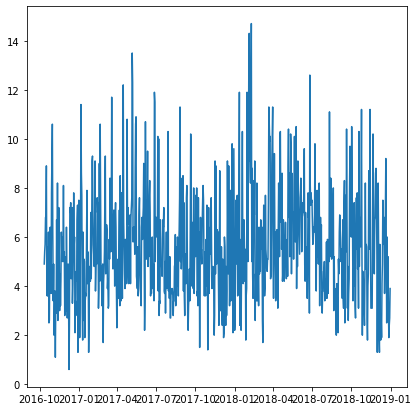

In [32]:
# plot predictions
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(features.iloc[ntrain:].index,y_test) # plot actual wind speed
plt.plot(features.iloc[ntrain:].index, y_test_pred) # plot predicted wind speed, y is the prediction results on testing data

# # PLOT TRAINING DATA HERE # #





# # INCREASE X TICK SPACING, UPDATE LEGEND # #
plt.xticks(features.index[::182], rotation = 45) # X-Ticks are spaced once every 30 days. 
myFmt = mdates.DateFormatter('%b-%y') # This shows day-month-year. Switch to month-year or annually
plt.gca().xaxis.set_major_formatter(myFmt)
plt.legend(('Test Label','Test Prediction','Train Label','Train Prediction'), fontsize=12, loc=1) # Add entries for training predictions and truth
plt.ylabel('Wind speed', fontsize=12)
#plt.show()

# # Plot the feature importances # #
nfeatures = 10
fi = improved_clf.feature_importances_ # get feature importances, regr is the regressor
fi_sort = np.argsort(fi)[::-1] # sort importances most to least
plt.subplot(1,2,2)
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]], width=1, \
        tick_label=features.columns.values[fi_sort[0:nfeatures]]) # plot features importances
plt.ylabel('Feature Importance (avg across trees)', fontsize=12)
plt.xticks(rotation = 45)
plt.show()

### Feature importance is the weighted impurity of a branch adjusted by its children nodes and normalized by the impurities of all branches. The Random Forest feature importances are averaged over all regression trees.

In [42]:
len(features.columns)

23

### Exploratory Data Analysis

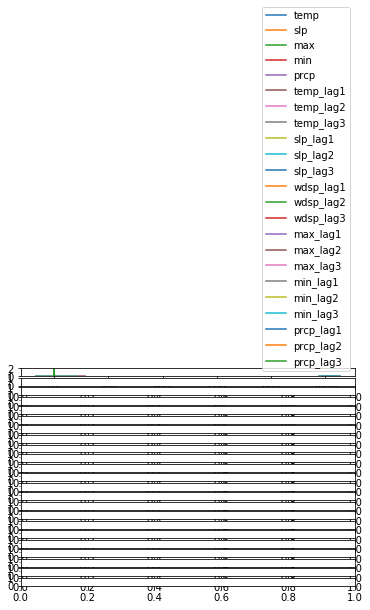

In [45]:
fig, ax = plt.subplots(23)
for col in features.columns:
    sns.kdeplot(features[col], ax = ax[0])
    


### Feature Selection

In [15]:
features2 = features.drop(['max_lag1', 'max_lag2', 'max_lag3', 'min_lag1', 'min_lag2', 'min_lag3'], axis=1)

In [16]:

# Use 20% test split (80% training + validation)
ntrain = int(len(features2)*0.8)
x_test = features2.iloc[ntrain:,:]
y_test = ylabel[ntrain:]
indices = np.arange(ntrain)

# Split remaining 80% into training-validation sets (of original data)
x_train, x_val, y_train, y_val, train_ind, val_ind = train_test_split(features2.iloc[0:ntrain,:], ylabel[0:ntrain], indices, 
                                                  test_size=0.2, random_state=1)

# Scale features. Fit scaler on training only.
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [17]:
features2.head()

,temp,slp,mxpsd,max,min,prcp,temp_lag1,temp_lag2,temp_lag3,slp_lag1,...,slp_lag3,wdsp_lag1,wdsp_lag2,wdsp_lag3,mxpsd_lag1,mxpsd_lag2,mxpsd_lag3,prcp_lag1,prcp_lag2,prcp_lag3
Datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-04,7.9,998.0,9.9,19.4,-4.0,0.00,9.2,-6.9,-8.3,996.6,...,1035.4,2.0,4.2,1.4,9.9,9.9,5.1,0.04,0.00,0.01
2008-01-05,6.8,995.4,12.0,18.9,-4.9,0.13,7.9,9.2,-6.9,998.0,...,1022.2,3.4,2.0,4.2,9.9,9.9,9.9,0.00,0.04,0.00
2008-01-06,4.0,993.5,13.0,9.7,2.7,0.09,6.8,7.9,9.2,995.4,...,996.6,9.7,3.4,2.0,12.0,9.9,9.9,0.13,0.00,0.04
2008-01-07,4.7,1001.9,2.9,5.5,3.0,0.05,4.0,6.8,7.9,993.5,...,998.0,8.5,9.7,3.4,13.0,12.0,9.9,0.09,0.13,0.00
2008-01-08,-4.2,1011.6,2.9,5.5,-8.3,0.06,4.7,4.0,6.8,1001.9,...,995.4,0.6,8.5,9.7,2.9,13.0,12.0,0.05,0.09,0.13


In [18]:
features2.columns

Index(['temp', 'slp', 'mxpsd', 'max', 'min', 'prcp', 'temp_lag1', 'temp_lag2',
       'temp_lag3', 'slp_lag1', 'slp_lag2', 'slp_lag3', 'wdsp_lag1',
       'wdsp_lag2', 'wdsp_lag3', 'mxpsd_lag1', 'mxpsd_lag2', 'mxpsd_lag3',
       'prcp_lag1', 'prcp_lag2', 'prcp_lag3'],
      dtype='object')

In [74]:
import seaborn as sns

In [19]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [20]:
get_top_abs_correlations(features, n=10)

temp       max         0.981961
temp_lag1  max_lag1    0.981939
temp_lag2  max_lag2    0.981917
temp_lag3  max_lag3    0.981899
temp       min         0.980842
temp_lag1  min_lag1    0.980823
temp_lag2  min_lag2    0.980802
temp_lag3  min_lag3    0.980787
max        max_lag1    0.968172
max_lag1   max_lag2    0.968134
dtype: float64

In [21]:
get_top_abs_correlations(data, n=10)

KeyError: ('max', 'stn')

In [77]:
improved_clf2 = RandomForestRegressor(n_estimators = 100) 

In [78]:
improved_clf2.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [79]:
y_test_pred = improved_clf2.predict(x_test)
y_train_pred = improved_clf2.predict(x_train)
y_val_pred = improved_clf2.predict(x_val)

In [80]:
from sklearn.metrics import mean_squared_error

In [81]:
mean_squared_error(y_test, y_test_pred)

2.0212616795994993

In [82]:
mean_squared_error(ylabel[train_ind], y_train_pred)

0.23321284449667065

In [83]:
mean_squared_error(ylabel[val_ind], y_val_pred)

1.9460275477308293

In [150]:
n_estimators_values = [50, 100, 300, 800, 1500, 2000]
max_features_values = ["log2", "sqrt", "auto"]
max_depth_values = [5, 7, 10, 15, 20, 50, 80, 150, None]
min_samples_split_values = [2, 3, 5, 7, 10]
bootstrap_values = [True, False]
criterion_values = ["mse", "mae"]

In [151]:
search_grid = {
    'n_estimators' : n_estimators_values,
    'max_features' : max_features_values,
    'max_depth' : max_depth_values,
    'min_samples_split' : min_samples_split_values,
    'bootstrap' : bootstrap_values,
    'criterion' : criterion_values,
}

In [152]:
clf3 = RandomForestRegressor()

In [153]:
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit

In [154]:
split_index = [-1 if x in train_ind else 0 for x in range(0, ntrain)]

In [155]:
pds = PredefinedSplit(test_fold = split_index)

In [156]:
rf_cross_validator2 = RandomizedSearchCV(estimator = clf3, param_distributions = search_grid, cv = pds, n_iter = 1000, verbose = 2, n_jobs = -1)

In [157]:
rf_cross_validator2.fit(features2.iloc[:ntrain], ylabel[:ntrain])

Fitting 1 folds for each of 1000 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 66.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 122.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 210.9min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  0])),
                   error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimat...
                   iid='warn', n_iter=1000, n_jobs=-1,
                   param_d

In [158]:
rf_cross_validator2.best_params_

{'n_estimators': 100,
 'min_samples_split': 3,
 'max_features': 'auto',
 'max_depth': 80,
 'criterion': 'mae',
 'bootstrap': True}

In [22]:
improved_clf3 = RandomForestRegressor(n_estimators = 100, min_samples_split = 3, max_features='auto', max_depth=80, criterion='mae', bootstrap=True) 

In [23]:
improved_clf3.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=80,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [24]:
from sklearn.metrics import mean_squared_error


In [25]:
y_test_pred = improved_clf3.predict(x_test)
y_train_pred = improved_clf3.predict(x_train)
y_val_pred =  improved_clf3.predict(x_val)

In [26]:
mean_squared_error(y_test, y_test_pred)

2.0151539940550682

In [27]:
mean_squared_error(ylabel[train_ind], y_train_pred)

0.2543750546415981

In [28]:
mean_squared_error(ylabel[val_ind], y_val_pred)

1.9042181741001556

In [29]:
train_pred_df = pd.Series(data = y_train_pred, index = features.iloc[train_ind].index)
val_pred_df = pd.Series(data = y_val_pred, index = features.iloc[val_ind].index)

In [30]:
train_pred_df = train_pred_df.append(val_pred_df)

In [31]:
train_pred_df = train_pred_df.sort_index()

In [32]:
train_pred_df

Datetime
2008-01-04    3.8200
2008-01-05    8.3660
2008-01-06    7.7445
2008-01-07    1.2255
2008-01-08    1.1555
               ...  
2016-10-07    4.3435
2016-10-08    1.6180
2016-10-09    2.6930
2016-10-10    4.1060
2016-10-11    7.5345
Length: 3192, dtype: float64

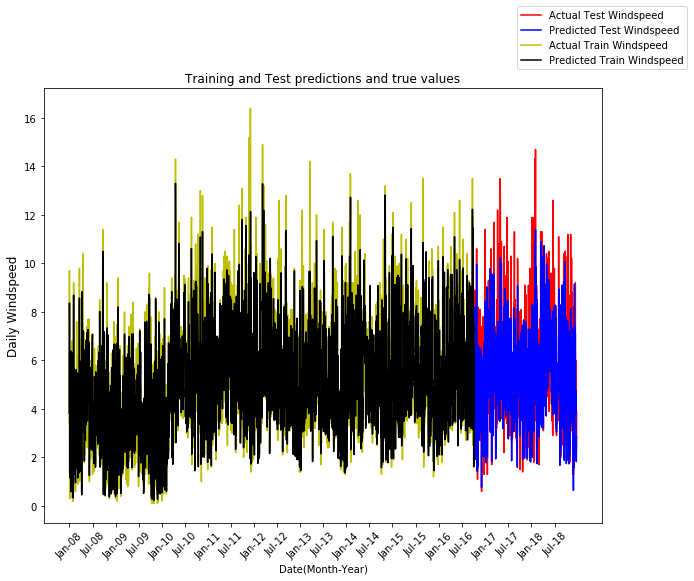

In [34]:
# plot predictions
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(features.iloc[ntrain:].index,y_test, 'r', label="Actual Test Windspeed") # plot actual temperature
ax.plot(features.iloc[ntrain:].index, y_test_pred, 'b', label="Predicted Test Windspeed") # plot predicted temperature

# # PLOT THE PREDICTED TRAINING AND VALIDATION DATA HERE # #
ax.plot(features.iloc[0:ntrain].index, ylabel[0:ntrain], 'y', label="Actual Train Windspeed")
ax.plot(features.iloc[0:ntrain].index, train_pred_df, 'k', label="Predicted Train Windspeed")

#plt.plot(features.iloc[val_ind].index, y_val, 'm', label="Actual Val Temperature")
#plt.plot(features.iloc[val_ind].index, y_val_pred, 'c', label="Predicted Val Temperature")

# # INCREASE X TICK SPACING, UPDATE LEGEND # #
ax.set_xticks(features.iloc[:].index[::182]) # set xticks to monthly
ax.set_xticklabels(ax.get_xticks(), rotation=45)
myFmt = mdates.DateFormatter('%b-%y')
plt.gca().xaxis.set_major_formatter(myFmt)
ax.set_title('Training and Test predictions and true values')
ax.set_ylabel('Daily Windspeed', fontsize=12)
ax.set_xlabel('Date(Month-Year)')
lgd = ax.legend(bbox_to_anchor=(1, 1.2), loc='upper center')
fig.savefig("problem 2b.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# # Plot the feature importances # #


### XGboost

In [103]:
!conda install --yes xgboost 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            1_gnu          22 KB  conda-forge
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    certifi-2020.12.5          |   py37h89c1867_1         143 KB  conda-forge
    libedit-3.1.20191231       |       h46ee950_2         121 KB  conda-forge
    libgcc-ng-9.3.0            |      h2828fa1_19         7.8 MB  conda-forge
    libgomp-9.3

In [104]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [35]:
from sklearn.neural_network import MLPRegressor 

In [36]:
clf4 = MLPRegressor(hidden_layer_sizes = 100, random_state = 60, verbose = True)

In [37]:
clf4.fit(x_train, y_train)

Iteration 1, loss = 14.14606566
Iteration 2, loss = 10.48645174
Iteration 3, loss = 7.16097757
Iteration 4, loss = 4.50057419
Iteration 5, loss = 2.97059173
Iteration 6, loss = 2.50099423
Iteration 7, loss = 2.45906974
Iteration 8, loss = 2.43288690
Iteration 9, loss = 2.38082654
Iteration 10, loss = 2.34041282
Iteration 11, loss = 2.30042141
Iteration 12, loss = 2.26084787
Iteration 13, loss = 2.21991416
Iteration 14, loss = 2.17702497
Iteration 15, loss = 2.13149266
Iteration 16, loss = 2.08249940
Iteration 17, loss = 2.02835388
Iteration 18, loss = 1.96637850
Iteration 19, loss = 1.90444246
Iteration 20, loss = 1.84561432
Iteration 21, loss = 1.78486424
Iteration 22, loss = 1.72883949
Iteration 23, loss = 1.67240769
Iteration 24, loss = 1.61653409
Iteration 25, loss = 1.56474671
Iteration 26, loss = 1.51586258
Iteration 27, loss = 1.47497745
Iteration 28, loss = 1.42791508
Iteration 29, loss = 1.39120918
Iteration 30, loss = 1.35296810
Iteration 31, loss = 1.31760100
Iteration 32, l

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=100, learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=60, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [38]:
y_test_pred = clf4.predict(x_test)
y_train_pred = clf4.predict(x_train)
y_val_pred = clf4.predict(x_val)

In [39]:
mean_squared_error(y_test, y_test_pred)

1.9893927854452491

In [40]:
mean_squared_error(ylabel[train_ind], y_train_pred)

1.577149571309534

In [41]:
mean_squared_error(ylabel[val_ind], y_val_pred)

1.7565439431183483

In [42]:
train_pred_df = pd.Series(data = y_train_pred, index = features.iloc[train_ind].index)
val_pred_df = pd.Series(data = y_val_pred, index = features.iloc[val_ind].index)

In [43]:
train_pred_df = train_pred_df.append(val_pred_df)

In [44]:
train_pred_df = train_pred_df.sort_index()

In [45]:
train_pred_df

Datetime
2008-01-04    4.220922
2008-01-05    5.865083
2008-01-06    7.271992
2008-01-07    1.852735
2008-01-08    1.251335
                ...   
2016-10-07    4.648056
2016-10-08    2.632581
2016-10-09    4.490611
2016-10-10    3.969700
2016-10-11    7.272395
Length: 3192, dtype: float64

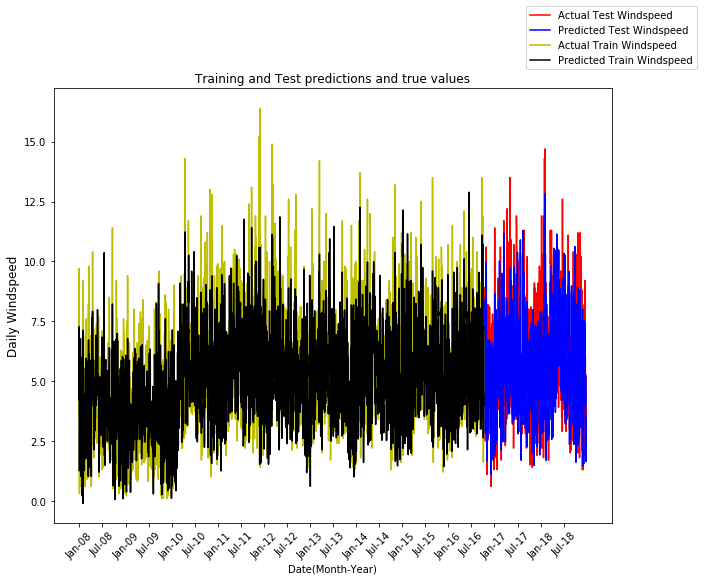

In [46]:
# plot predictions
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(features.iloc[ntrain:].index,y_test, 'r', label="Actual Test Windspeed") # plot actual temperature
ax.plot(features.iloc[ntrain:].index, y_test_pred, 'b', label="Predicted Test Windspeed") # plot predicted temperature

# # PLOT THE PREDICTED TRAINING AND VALIDATION DATA HERE # #
ax.plot(features.iloc[0:ntrain].index, ylabel[0:ntrain], 'y', label="Actual Train Windspeed")
ax.plot(features.iloc[0:ntrain].index, train_pred_df, 'k', label="Predicted Train Windspeed")

#plt.plot(features.iloc[val_ind].index, y_val, 'm', label="Actual Val Temperature")
#plt.plot(features.iloc[val_ind].index, y_val_pred, 'c', label="Predicted Val Temperature")

# # INCREASE X TICK SPACING, UPDATE LEGEND # #
ax.set_xticks(features.iloc[:].index[::182]) # set xticks to monthly
ax.set_xticklabels(ax.get_xticks(), rotation=45)
myFmt = mdates.DateFormatter('%b-%y')
plt.gca().xaxis.set_major_formatter(myFmt)
ax.set_title('Training and Test predictions and true values')
ax.set_ylabel('Daily Windspeed', fontsize=12)
ax.set_xlabel('Date(Month-Year)')
lgd = ax.legend(bbox_to_anchor=(1, 1.2), loc='upper center')
fig.savefig("problem 3.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# # Plot the feature importances # #


In [142]:
features2.iloc[:ntrain].index

DatetimeIndex(['2008-01-04', '2008-01-05', '2008-01-06', '2008-01-07',
               '2008-01-08', '2008-01-09', '2008-01-10', '2008-01-11',
               '2008-01-12', '2008-01-13',
               ...
               '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05',
               '2016-10-06', '2016-10-07', '2016-10-08', '2016-10-09',
               '2016-10-10', '2016-10-11'],
              dtype='datetime64[ns]', name='Datetime', length=3192, freq=None)